In [1]:
import sys
sys.path.append('../../functions')

import numpy as np
import matplotlib.pyplot as plt
import glob
from output_funcs import openFile, ODea, NC, PrevalenceTheoryM3
from output_funcs import PrevalenceTheoryM1, RoI_fluctuationsM2
from output_funcs import PrevalenceTheoryM2, NCM2
from output_funcs import RoI_fluctuationsM1M3, RoI_approximation, banddepth_rolling_sizes, rolling_sizes
from scipy.integrate import odeint
import pandas as pd
from statsmodels.graphics.functional import banddepth


In [2]:
files = glob.glob('../data/dataHPC/*')

In [3]:
param_all = {'repeats': 500,
            'T': 500, 
            'BT': 300,
            'p': 1/500,
            'ST': 0}
ts = np.arange(0, param_all['T']+param_all['BT'], 0.1)


# Simulations of RoI

$n_c = Poi(\beta SI)=Poi(\lambda)$

RoI: $\lambda = \beta SI $

### Theory 
$var(\lambda) = var(\beta SI)$

$\omega = \beta \Delta t (1-2\phi) \zeta $

$$ d \omega(t) = (\beta(1-2\phi)-\gamma) \omega dt + \beta(1-2\phi) \sqrt{\beta \phi (1-\phi) +\gamma \phi} dW_t $$

### Simulations
To estimate RoI from $n$: 
- RoI, $\lambda$, is the mean (and variance) of $n_c$
- For each simulation of $n_c$, we take the rolling mean to get the mean of $n_c$ to give an estimation of $\lambda$.
- Then we average over all simulations of $\lambda$ to give the mean of RoI and we calculate the variance over all simulations of $\lambda$ will give the variance of RoI
- NB: should work if take the rolling variance of $n_c$ instead of rolling mean (property of Poisson process)

To estimate RoI from $I$:
- RoI equals $\beta S I$
- Calculate $\lambda$ by taking the product of Gillespie outputs of $\beta S I$



In [4]:
def banddepth_rolling_sizes(matrix_results, sizes,
                            ax, color, depths = [5, 25, 50, 75, 95],
                           T = 500, BT = 300):
    depth = banddepth(matrix_results)
    ix_depth = np.argsort(depth)[::-1]
    median_curve = matrix_results[ix_depth[0], :]
    
    for depths in [5, 25, 50, 75, 95][::-1]:
        ix_IQR_depth = matrix_results.shape[0]*depths // 100
        lower_depth = matrix_results[ix_depth[0:ix_IQR_depth], :].min(axis=0)
        upper_depth = matrix_results[ix_depth[0:ix_IQR_depth], :].max(axis=0)
        alpha_depth = 1- (depths/100)
        ax.fill_between(range(T+BT),
                        lower_depth, upper_depth,
                        color=color, alpha = alpha_depth, label = str(depths)+'% of curves')
        
        
    ax.plot(range(T+BT), median_curve, c = 'k', label = 'Median (BW = '+str(sizes[ix_depth[0]])+')')
    ax.legend()
    

In [5]:
def rolling_sizes(matrix_results, ax, color, sizes , group =4, T = 500, BT = 300):
    alpha_shade = np.linspace(0.1,1, len(sizes) // group )
    index = 0
    alpha_index = 0
    for  i in range(len(sizes) // group):
        lower_depth = matrix_results[index:index+group, :].min(axis=0)
        upper_depth = matrix_results[index:index+group, :].max(axis=0)
        ax.fill_between(range(T+BT),
                        lower_depth, upper_depth,
                        color=color, alpha = alpha_shade[alpha_index], 
                        label = 'window sizes '+str(sizes[index])+'-'+str(sizes[index+group-1]))
        alpha_index = alpha_index+1
        index = index + 4
    ax.legend()


# Emergence Results

In [6]:
emFiles = [file for file in files if 'emergence' in file]


In [7]:
parametersEm = {'beta0': 0.12, 
               'gamma':0.2,
                'I0': [0,0,0], 
               'nu': 0.001,
               'mu': 0,
               'p_0': 0,
               'psign': 1,
               'N': 100000,
               }

In [8]:
EmResults = openFile(filePath = [file for file in emFiles if 'Em_' in file][0], 
                     realisations = param_all['repeats'],
                     T=param_all['T'],
                     BT= param_all['BT'],
                     ST= param_all['ST'],
                    beta0=parametersEm['beta0'],
                     gamma=parametersEm['gamma'],
                     nu=parametersEm['nu'],
                     mu=parametersEm['mu'],
                     p0=parametersEm['p_0'],
                     p = param_all['p'],
                     Initial=parametersEm['I0'],
                     sign =parametersEm['psign'],
                     TYPE='Ext',
                     functionPrev=PrevalenceTheoryM3,
                     functionInc=NC,
                     functionOdea= ODea)
FixResults = openFile(filePath = [file for file in emFiles if 'Fix' in file][0], 
                     realisations = param_all['repeats'],
                     T=param_all['T'],
                     BT= param_all['BT'],
                     ST= param_all['ST'],
                      beta0=parametersEm['beta0'],
                     gamma=parametersEm['gamma'],
                     nu=parametersEm['nu'],
                     mu=parametersEm['mu'],
                     p0=parametersEm['p_0'],
                     p = param_all['p'],
                     Initial=parametersEm['I0'],
                     sign =parametersEm['psign'],
                     TYPE='Fix',
                     functionPrev=PrevalenceTheoryM3,
                     functionInc=NC,
                     functionOdea= ODea)

In [9]:
r0_1_t = (parametersEm['gamma']/parametersEm['beta0']-1)/param_all['p'] + param_all['BT']

In [10]:
rollingSizes = np.arange(10, 130, 5)
results = EmResults
result_type='Ext'
emRollingRangeMEANVAR = np.zeros(shape=(len(rollingSizes), param_all['T']+param_all['BT']))

emRollingRangeVARVAR = np.zeros(shape=(len(rollingSizes),param_all['T']+param_all['BT']))
fixRollingRange = np.zeros(shape=(len(rollingSizes), param_all['T']+param_all['BT']))

for index, BW in enumerate(rollingSizes):
    lambda_em, lambda_mean, lambda_var, betachange = RoI_approximation(EmResults,
                                                                       result_type,
                                                                       parametersEm['beta0'],
                                                                       param_all['BT'],
                                                                       param_all['T'],
                                                                       param_all['ST'], 
                                                                       parametersEm['nu'],
                                                                       parametersEm['gamma'],
                                                                       param_all['p'],
                                                                       sign =parametersEm['psign'],
                                                                       N=parametersEm['N'],
                                                                       rolling_window=BW)
    
    emRollingRangeMEANVAR[index,:] = np.var(lambda_mean,0)/parametersEm['N']
    emRollingRangeVARVAR[index,:] = np.var(lambda_var/parametersEm['N'], 0 )
    
    lambda_fix, lambda_mean, lambda_var, betachange = RoI_approximation(FixResults,
                                                                        'Fix',
                                                                        parametersEm['beta0'],
                                                                        param_all['BT'],
                                                                        param_all['T'],
                                                                        param_all['ST'], 
                                                                        parametersEm['nu'],
                                                                        parametersEm['gamma'],
                                                                        param_all['p'],
                                                                        sign =parametersEm['psign'],
                                                                        N=parametersEm['N'],
                                                                        rolling_window=BW)
    fixRollingRange[index,:] = np.var(lambda_mean,0)/parametersEm['N']


In [11]:
roi_theory_em = odeint(RoI_fluctuationsM1M3, parametersEm['I0'],ts, 
             args = ('Ext', param_all['BT'], parametersEm['beta0'],
                      parametersEm['gamma'],
                      parametersEm['nu'],param_all['p'],
                      parametersEm['psign'], ))

roi_theory_fix = odeint(RoI_fluctuationsM1M3, parametersEm['I0'],ts, 
             args = ('Fix', param_all['BT'], parametersEm['beta0'],
                      parametersEm['gamma'],
                      parametersEm['nu'],param_all['p'],
                      parametersEm['psign'], ))

/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/statsmodels/graphics/functional.py:828: RuntimeWarning: invalid value encountered in greater_equal
  res = np.logical_and(curve >= xb.min(axis=0),
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/statsmodels/graphics/functional.py:829: RuntimeWarning: invalid value encountered in less_equal
  curve <= xb.max(axis=0))
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/statsmodels/graphics/functional.py:828: RuntimeWarning: invalid value encountered in greater_equal
  res = np.logical_and(curve >= xb.min(axis=0),
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/statsmodels/graphics/functional.py:829: RuntimeWarning: invalid value encountered in less_equal
  curve <= xb.max(axis=0))


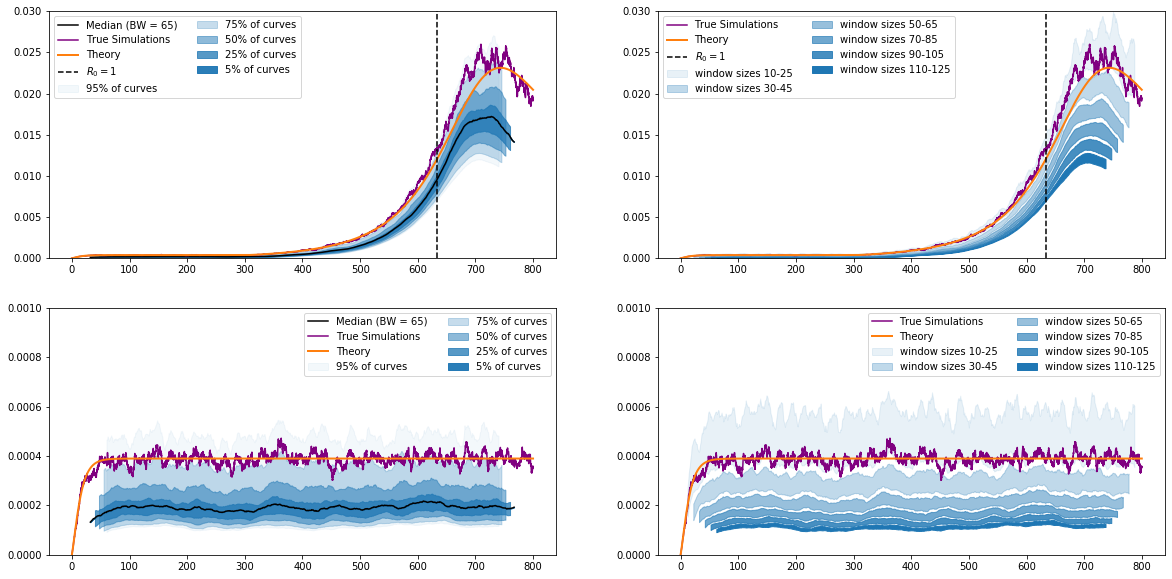

In [12]:
fig, ax = plt.subplots(2,2, figsize = (20,10))
ax = ax.ravel()


banddepth_rolling_sizes(emRollingRangeMEANVAR,
                        sizes = rollingSizes,
                        ax = ax[0],
                        color = 'tab:blue')
ax[0].plot(ts, np.var(lambda_em,0)/parametersEm['N'],
           c='purple',
           label = 'True Simulations')
ax[0].plot(ts,roi_theory_em[:,1],
           c='tab:orange',
           lw =2, 
           label = 'Theory')
ax[0].plot([r0_1_t, r0_1_t], [0,1], 
           '--', 
           c='k', 
           label = r'$R_0 = 1$')
ax[0].set_ylim([0,0.03])
ax[0].legend(ncol=2)

rolling_sizes(emRollingRangeMEANVAR,
              sizes = rollingSizes,
              ax = ax[1],
              color = 'tab:blue')
ax[1].plot(ts, np.var(lambda_em,0)/parametersEm['N'],
           c='purple',
           label = 'True Simulations')
ax[1].plot(ts,roi_theory_em[:,1],
           c='tab:orange',
           lw =2,
           label = 'Theory')
ax[1].plot([r0_1_t, r0_1_t], [0,1], 
           '--', 
           c='k', 
           label = r'$R_0 = 1$')
ax[1].set_ylim([0,0.03])
ax[1].legend(ncol=2)




banddepth_rolling_sizes(fixRollingRange,
                        sizes = rollingSizes,
                        ax = ax[2],
                        color = 'tab:blue')

ax[2].plot(ts, np.var(lambda_fix,0)/parametersEm['N'],
           c='purple',
           label = 'True Simulations')
ax[2].plot(ts,roi_theory_fix[:,1],
           c='tab:orange',
           lw =2,
           label = 'Theory')
ax[2].set_ylim([0,0.001])
ax[2].legend(ncol=2)

rolling_sizes(fixRollingRange,
              sizes = rollingSizes,
              ax = ax[3],
              color = 'tab:blue')

ax[3].plot(ts, np.var(lambda_fix,0)/parametersEm['N'],
           c='purple',
           label = 'True Simulations')
ax[3].plot(ts,roi_theory_fix[:,1],
           c='tab:orange',
           lw =2,
           label = 'Theory')
ax[3].set_ylim([0,0.001])
ax[3].legend(ncol=2)

# Elimination data

# Changing $\beta$ (SIS with social distancing) 

In [13]:
parametersExt = {'beta0': 1, 
               'gamma':0.2,
                'I0': [0.8,0,0], 
               'nu': 0,
               'mu': 0,
               'p_0': 0,
               'psign': -1,
                'N': 10000}

In [14]:
extFiles = [file for file in files if '500' in file]

In [15]:
ExtResults = openFile(filePath = [file for file in extFiles if 'Ext' in file][0], 
                      realisations = param_all['repeats'],
                     T=param_all['T'],
                     BT= param_all['BT'],
                     ST= param_all['ST'],
                      beta0=parametersExt['beta0'],
                     gamma=parametersExt['gamma'],
                     nu=parametersExt['nu'],
                     mu=parametersExt['mu'],
                     p0=parametersExt['p_0'],
                     p = param_all['p'],
                     Initial=parametersExt['I0'],
                     sign =parametersExt['psign'],
                     TYPE='Ext',
                     functionPrev=PrevalenceTheoryM1,
                     functionInc=NC)
FixResults = openFile(filePath = [file for file in extFiles if 'Fix' in file][0], 
                      realisations = param_all['repeats'],
                     T=param_all['T'],
                     BT= param_all['BT'],
                     ST= param_all['ST'],
                      beta0=parametersExt['beta0'],
                     gamma=parametersExt['gamma'],
                     nu=parametersExt['nu'],
                     mu=parametersExt['mu'],
                     p0=parametersExt['p_0'],
                     p = param_all['p'],
                     Initial=parametersExt['I0'],
                     sign =parametersExt['psign'],
                     TYPE='Fix',
                     functionPrev=PrevalenceTheoryM1,
                     functionInc=NC)

In [16]:
r0_1_t = (parametersExt['psign']*parametersExt['gamma']/parametersExt['beta0']+1)/param_all['p'] + param_all['BT']


In [17]:
rollingSizes = np.arange(10, 130, 5)
results = EmResults
result_type='Ext'
extRollingRangeMEANVAR = np.zeros(shape=(len(rollingSizes), param_all['T']+param_all['BT']))

extRollingRangeVARVAR = np.zeros(shape=(len(rollingSizes),param_all['T']+param_all['BT']))
fixRollingRange = np.zeros(shape=(len(rollingSizes), param_all['T']+param_all['BT']))

for index, BW in enumerate(rollingSizes):
    lambda_ext, lambda_mean, lambda_var, betachange = RoI_approximation(ExtResults,
                                                                       result_type,
                                                                       parametersExt['beta0'],
                                                                       param_all['BT'],
                                                                       param_all['T'],
                                                                       param_all['ST'], 
                                                                       parametersExt['nu'],
                                                                       parametersExt['gamma'],
                                                                       param_all['p'],
                                                                       sign =parametersExt['psign'],
                                                                       N=parametersExt['N'],
                                                                       rolling_window=BW)
    
    extRollingRangeMEANVAR[index,:] = np.var(lambda_mean,0)/parametersExt['N']
    extRollingRangeVARVAR[index,:] = np.var(lambda_var/parametersExt['N'], 0 )
    
    lambda_fix, lambda_mean, lambda_var, betachange = RoI_approximation(FixResults,
                                                                        'Fix',
                                                                        parametersExt['beta0'],
                                                                        param_all['BT'],
                                                                        param_all['T'],
                                                                        param_all['ST'], 
                                                                        parametersExt['nu'],
                                                                        parametersExt['gamma'],
                                                                        param_all['p'],
                                                                        sign =parametersExt['psign'],
                                                                        N=parametersExt['N'],
                                                                        rolling_window=BW)
    fixRollingRange[index,:] = np.var(lambda_mean,0)/parametersExt['N']

In [18]:
roi_theory_ext = odeint(RoI_fluctuationsM1M3, parametersExt['I0'],ts, 
             args = ('Ext', param_all['BT'], parametersExt['beta0'],
                      parametersExt['gamma'],
                      parametersExt['nu'],param_all['p'],
                      parametersExt['psign'], ))

roi_theory_fix = odeint(RoI_fluctuationsM1M3, parametersExt['I0'],ts, 
             args = ('Fix', param_all['BT'], parametersExt['beta0'],
                      parametersExt['gamma'],
                      parametersExt['nu'],param_all['p'],
                      parametersExt['psign'], ))

/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/statsmodels/graphics/functional.py:828: RuntimeWarning: invalid value encountered in greater_equal
  res = np.logical_and(curve >= xb.min(axis=0),
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/statsmodels/graphics/functional.py:829: RuntimeWarning: invalid value encountered in less_equal
  curve <= xb.max(axis=0))
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/statsmodels/graphics/functional.py:828: RuntimeWarning: invalid value encountered in greater_equal
  res = np.logical_and(curve >= xb.min(axis=0),
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/statsmodels/graphics/functional.py:829: RuntimeWarning: invalid value encountered in less_equal
  curve <= xb.max(axis=0))


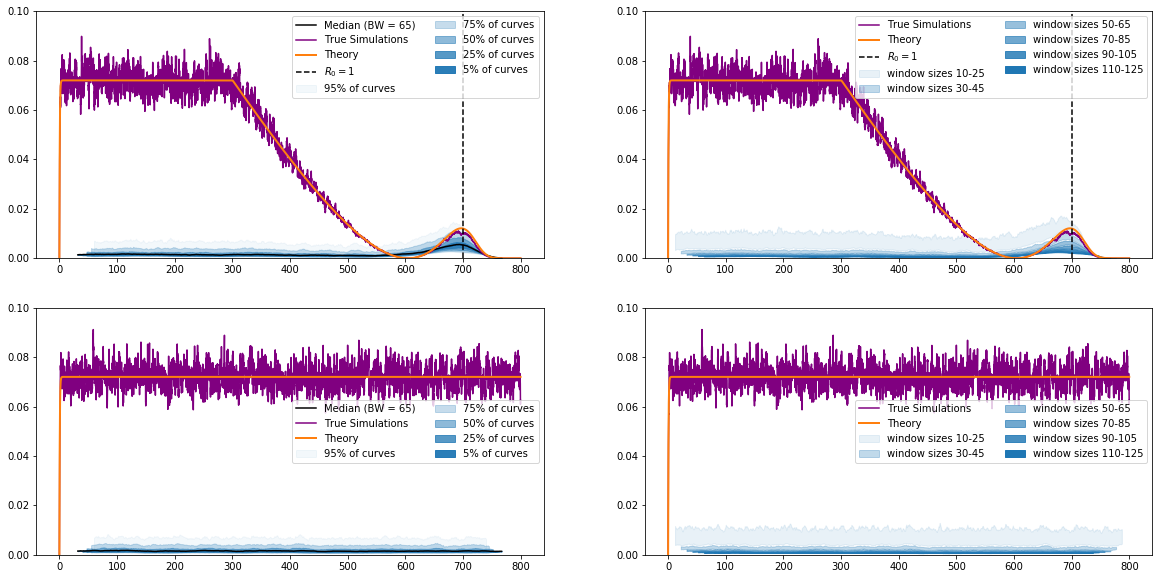

In [19]:
fig, ax = plt.subplots(2,2, figsize = (20,10))
ax = ax.ravel()


banddepth_rolling_sizes(extRollingRangeMEANVAR,
                        sizes = rollingSizes,
                        ax = ax[0],
                        color = 'tab:blue')
ax[0].plot(ts, np.var(lambda_ext,0)/parametersExt['N'],
           c='purple',
           label = 'True Simulations')
ax[0].plot(ts,roi_theory_ext[:,1],
           c='tab:orange',
           lw =2, 
           label = 'Theory')
ax[0].plot([r0_1_t, r0_1_t], [0,1], 
           '--', 
           c='k', 
           label = r'$R_0 = 1$')
ax[0].set_ylim([0,0.1])
ax[0].legend(ncol=2)

rolling_sizes(extRollingRangeMEANVAR,
              sizes = rollingSizes,
              ax = ax[1],
              color = 'tab:blue')
ax[1].plot(ts, np.var(lambda_ext,0)/parametersExt['N'],
           c='purple',
           label = 'True Simulations')
ax[1].plot(ts,roi_theory_ext[:,1],
           c='tab:orange',
           lw =2,
           label = 'Theory')
ax[1].plot([r0_1_t, r0_1_t], [0,1], 
           '--', 
           c='k', 
           label = r'$R_0 = 1$')
ax[1].set_ylim([0,0.1])
ax[1].legend(ncol=2)




banddepth_rolling_sizes(fixRollingRange,
                        sizes = rollingSizes,
                        ax = ax[2],
                        color = 'tab:blue')

ax[2].plot(ts, np.var(lambda_fix,0)/parametersExt['N'],
           c='purple',
           label = 'True Simulations')
ax[2].plot(ts,roi_theory_fix[:,1],
           c='tab:orange',
           lw =2,
           label = 'Theory')
ax[2].set_ylim([0,0.1])
ax[2].legend(loc = 'center right', ncol=2)

rolling_sizes(fixRollingRange,
              sizes = rollingSizes,
              ax = ax[3],
              color = 'tab:blue')

ax[3].plot(ts, np.var(lambda_fix,0)/parametersExt['N'],
           c='purple',
           label = 'True Simulations')
ax[3].plot(ts,roi_theory_fix[:,1],
           c='tab:orange',
           lw =2,
           label = 'Theory')
ax[3].set_ylim([0,0.1])
ax[3].legend(loc = 'center right', ncol=2)

# Vaccination (SIS with increasing vaccine coverage)

In [20]:
vaccFiles = [file for file in files if 'vacc' in file]

In [21]:
parametersVacc = {'beta0': 1, 
               'gamma':0.18,
                'I0':  [0.2, 0.8, 0,0,0], 
               'nu': 0,
               'mu': 0.02,
               'p_0': 0,
               'psign': 0,
                 'N': 10000}

In [22]:
VaccResults = openFile(filePath = [file for file in vaccFiles if 'Ext' in file][0], 
                     realisations = param_all['repeats'],
                     T=param_all['T'],
                     BT= param_all['BT'],
                     ST= param_all['ST'],
                      beta0=parametersVacc['beta0'],
                     gamma=parametersVacc['gamma'],
                     nu=parametersVacc['nu'],
                     mu=parametersVacc['mu'],
                     p0=parametersVacc['p_0'],
                     p = param_all['p'],
                     Initial=parametersVacc['I0'],
                     sign =parametersVacc['psign'],
                     TYPE='Ext',
                     functionPrev=PrevalenceTheoryM2,
                     functionInc=NCM2)
FixResults = openFile(filePath = [file for file in vaccFiles if 'Fix' in file][0], 
                    realisations = param_all['repeats'],
                     T=param_all['T'],
                     BT= param_all['BT'],
                     ST= param_all['ST'],
                      beta0=parametersVacc['beta0'],
                     gamma=parametersVacc['gamma'],
                     nu=parametersVacc['nu'],
                     mu=parametersVacc['mu'],
                     p0=parametersVacc['p_0'],
                     p = param_all['p'],
                     Initial=parametersVacc['I0'],
                     sign =parametersVacc['psign'],
                     TYPE='Fix',
                     functionPrev=PrevalenceTheoryM2,
                     functionInc=NCM2)

In [23]:
r0_1_t = 400 +param_all['BT']

In [24]:
rollingSizes = np.arange(10, 130, 5)
vaccRollingRangeMEANVAR = np.zeros(shape=(len(rollingSizes),param_all['T']+param_all['BT']))

vaccRollingRangeVARVAR = np.zeros(shape=(len(rollingSizes), param_all['T']+param_all['BT']))
fixRollingRange = np.zeros(shape=(len(rollingSizes), param_all['T']+param_all['BT']))

for index, BW in enumerate(rollingSizes):
    lambda_vacc, lambda_mean, lambda_var, betachange = RoI_approximation(VaccResults,
                                                                       result_type,
                                                                       parametersVacc['beta0'],
                                                                       param_all['BT'],
                                                                       param_all['T'],
                                                                       param_all['ST'], 
                                                                       parametersVacc['nu'],
                                                                       parametersVacc['gamma'],
                                                                       param_all['p'],
                                                                       sign =parametersVacc['psign'],
                                                                       N=parametersVacc['N'],
                                                                       rolling_window=BW)
    
    vaccRollingRangeMEANVAR[index,:] = np.var(lambda_mean,0)/parametersVacc['N']
    vaccRollingRangeVARVAR[index,:] = np.var(lambda_var/parametersVacc['N'], 0 )
    
    lambda_fix, lambda_mean, lambda_var, betachange = RoI_approximation(FixResults,
                                                                        'Fix',
                                                                        parametersVacc['beta0'],
                                                                        param_all['BT'],
                                                                        param_all['T'],
                                                                        param_all['ST'], 
                                                                        parametersVacc['nu'],
                                                                        parametersVacc['gamma'],
                                                                        param_all['p'],
                                                                        sign =parametersVacc['psign'],
                                                                        N=parametersVacc['N'],
                                                                        rolling_window=BW)
    fixRollingRange[index,:] = np.var(lambda_mean,0)/parametersVacc['N']

In [25]:
roi_theory_vacc=RoI_fluctuationsM2(VaccResults['P_theory'], parametersVacc['beta0'])[1]
roi_theory_fix=RoI_fluctuationsM2(FixResults['P_theory'], parametersVacc['beta0'])[1]


/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/statsmodels/graphics/functional.py:828: RuntimeWarning: invalid value encountered in greater_equal
  res = np.logical_and(curve >= xb.min(axis=0),
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/statsmodels/graphics/functional.py:829: RuntimeWarning: invalid value encountered in less_equal
  curve <= xb.max(axis=0))
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/statsmodels/graphics/functional.py:828: RuntimeWarning: invalid value encountered in greater_equal
  res = np.logical_and(curve >= xb.min(axis=0),
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/statsmodels/graphics/functional.py:829: RuntimeWarning: invalid value encountered in less_equal
  curve <= xb.max(axis=0))


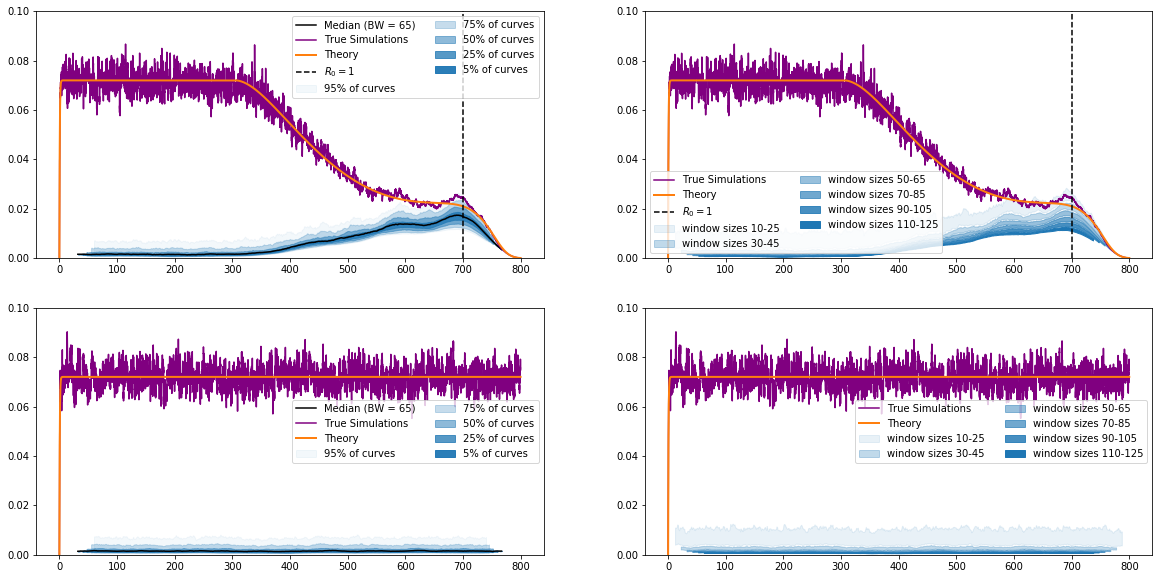

In [26]:
fig, ax = plt.subplots(2,2, figsize = (20,10))
ax = ax.ravel()


banddepth_rolling_sizes(vaccRollingRangeMEANVAR,
                        sizes = rollingSizes,
                        ax = ax[0],
                        color = 'tab:blue')
ax[0].plot(ts, np.var(lambda_vacc,0)/parametersVacc['N'],
           c='purple',
           label = 'True Simulations')
ax[0].plot(ts,roi_theory_vacc,
           c='tab:orange',
           lw =2, 
           label = 'Theory')
ax[0].plot([r0_1_t, r0_1_t], [0,1], 
           '--', 
           c='k', 
           label = r'$R_0 = 1$')

ax[0].set_ylim([0,0.1])
ax[0].legend(ncol=2)

rolling_sizes(vaccRollingRangeMEANVAR,
              sizes = rollingSizes,
              ax = ax[1],
              color = 'tab:blue')
ax[1].plot(ts, np.var(lambda_vacc,0)/parametersVacc['N'],
           c='purple',
           label = 'True Simulations')
ax[1].plot(ts,roi_theory_vacc,
           c='tab:orange',
           lw =2,
           label = 'Theory')
ax[1].plot([r0_1_t, r0_1_t], [0,1], 
           '--', 
           c='k', 
           label = r'$R_0 = 1$')
ax[1].set_ylim([0,0.1])
ax[1].legend(ncol=2)




banddepth_rolling_sizes(fixRollingRange,
                        sizes = rollingSizes,
                        ax = ax[2],
                        color = 'tab:blue')

ax[2].plot(ts, np.var(lambda_fix,0)/parametersVacc['N'],
           c='purple',
           label = 'True Simulations')
ax[2].plot(ts,roi_theory_fix,
           c='tab:orange',
           lw =2,
           label = 'Theory')

ax[2].set_ylim([0,0.1])
ax[2].legend(loc = 'center right', ncol=2)

rolling_sizes(fixRollingRange,
              sizes = rollingSizes,
              ax = ax[3],
              color = 'tab:blue')

ax[3].plot(ts, np.var(lambda_fix,0)/parametersVacc['N'],
           c='purple',
           label = 'True Simulations')
ax[3].plot(ts,roi_theory_fix,
           c='tab:orange',
           lw =2,
           label = 'Theory')
ax[3].set_ylim([0,0.1])
ax[3].legend(loc = 'center right', ncol=2)